In [12]:
import os
import numpy as np
import pandas as pd
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
# filename
temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_name = "IdealModel1"

Exception ignored in: <finalize object at 0x2c612723240; dead>
Traceback (most recent call last):
  File "c:\Environment\MiniConda\envs\backend\lib\weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 820, in _cleanup
    cls._rmtree(name)
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 816, in _rmtree
    _shutil.rmtree(name, onerror=onerror)
  File "c:\Environment\MiniConda\envs\backend\lib\shutil.py", line 759, in rmtree
    return _rmtree_unsafe(path, onerror)
  File "c:\Environment\MiniConda\envs\backend\lib\shutil.py", line 629, in _rmtree_unsafe
    onerror(os.unlink, fullname, sys.exc_info())
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 808, in onerror
    cls._rmtree(path)
  File "c:\Environment\MiniConda\envs\backend\lib\tempfile.py", line 816, in _rmtree
    _shutil.rmtree(name, onerror=onerror)
  File "c:\Environment\MiniCon

In [13]:
lnK = np.load("./lnK/lnK_real.npy")
# print(lnK.shape)
nlay = 1  # 含水层层数
nrow = 80  # 行数
ncol = 80  # 列数
print(lnK.reshape((nlay, nrow, ncol)))

print(np.exp(lnK.reshape((nlay, nrow, ncol))))


def plotmodelmap(mymodel):

    import matplotlib.pyplot as plt

    modelmap = flopy.plot.PlotMapView(model=mymodel, layer=0)

    grid = modelmap.plot_grid()

    plt.xlabel("Lx (m)", fontsize=14)

    plt.ylabel("Ly (m)", fontsize=14)

    plt.title("Grid", fontsize=15, fontweight="bold")

    plt.show()

[[[-0.5086 -0.4931 -0.4024 ... -0.7636 -0.7967 -0.8137]
  [-0.4513 -0.433  -0.3363 ... -0.66   -0.6946 -0.7157]
  [-0.3341 -0.3112 -0.2083 ... -0.5448 -0.5742 -0.5971]
  ...
  [-0.4001 -0.4566 -0.6676 ... -0.4698 -0.393  -0.3299]
  [-0.4399 -0.4939 -0.6918 ... -0.4612 -0.3859 -0.3254]
  [-0.5669 -0.6236 -0.8155 ... -0.4348 -0.363  -0.3062]]]
[[[0.60133686 0.61073019 0.66871321 ... 0.46598585 0.4508142  0.44321513]
  [0.63679977 0.64856049 0.71440875 ... 0.51685133 0.49927412 0.4888498 ]
  [0.71598218 0.73256735 0.81196341 ... 0.57995776 0.56315521 0.5504055 ]
  ...
  [0.67025302 0.63343366 0.51293815 ... 0.62512728 0.67502875 0.71899563]
  [0.64410083 0.6102418  0.50067404 ... 0.63052656 0.67983851 0.7222384 ]
  [0.56728129 0.53601132 0.44241806 ... 0.64739413 0.69558643 0.73623936]]]


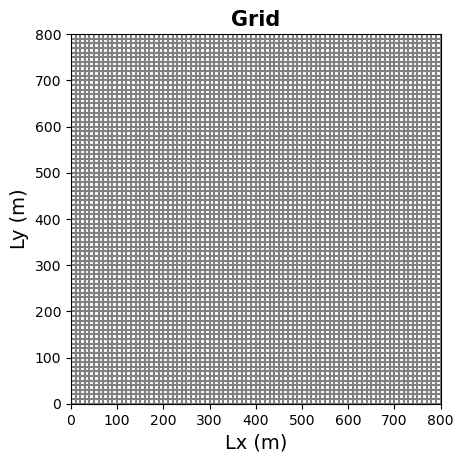

In [14]:
mf = flopy.modflow.Modflow(
    modelname=sim_name,
    exe_name="mf2005",
    version="mf2005",
    model_ws=sim_ws,
)

###################################################################################################
# 2. 离散DIS
Lx = 800.0  # x 长度
Ly = 800.0  # y 长度
ztop = 1.0  # z 顶部高程
zbot = 0.0  # z 底部高程
nlay = 1  # 含水层层数
nrow = 80  # 行数
ncol = 80  # 列数
delr = Lx / ncol  # x 方向步长
delc = Ly / nrow  # y 方向步长
botm = np.linspace(ztop, zbot, nlay + 1)  # z 每一层的底部高程
nper = 2  # 应力期数
perlen = [0.05, 5.0]  # 每个应力期的时间长度
nstp = [1, 100]  # 每个应力期的时间步数
steady = [True, False]  # 每个应力期是否稳态
# Unit System
itmuni = 4  # time units (4=days, 1=seconds)
lenuni = 2  # lenght units (2=meters, 3=centimeters)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm[1:],
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=steady,
    itmuni=itmuni,
    lenuni=lenuni,
)
plotmodelmap(mf)

In [15]:
# 3. 基础包BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1  # 最左边的列是常水头边界
strt = np.zeros((nlay, nrow, ncol), dtype=np.float32)  # 初始水头为0

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
##################################################################################################
# 4. LPF
vka = 10  # 当layvka>0时，vka表示水平渗透系数和垂直渗透系数的比值
# note 读取模型的渗透系数，三维数组(nlay, nrow, ncol)，注意读取的是lnK需要转换为K
# lnK = np.zeros((nlay, nrow, ncol))
lnK = np.load("./lnK/lnK_real.npy")
# print(lnK.shape)
hk = np.exp(lnK.reshape((nlay, nrow, ncol)))
# 水平各项异性默认为1，贮水率使用默认值。
lpf = flopy.modflow.ModflowLpf(mf, laytyp=0, hk=hk, layvka=1, vka=vka, ipakcb=53)
###################################################################################################
# 5. CHD 常水头边界
shead = 0.0  # 应力期开始时的水头
ehead = 0.0  # 应力期结束时的水头
bound_sp1 = []
for il in range(nlay):
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, shead, ehead])
# 应力期的数据少于应力期数时，flopy会自动复制最后一个应力期的数据，一直用到模拟结束
stress_period_data = {0: bound_sp1}
# Create the flopy chd object
chd = flopy.modflow.ModflowChd(mf, stress_period_data=stress_period_data)
#################################################################################################
# 6. 通过在右边界设置一排井来表示指定流量边界
pumping_rate1 = -20.0
pumping_rate2 = 0.0
wel_sp1 = []
for ir in range(nrow):
    wel_sp1.append([0, ir, ncol - 1, pumping_rate1])

wel_sp2 = []
for ir in range(nrow):
    wel_sp2.append([0, ir, ncol - 1, pumping_rate2])

stress_period_data = {0: wel_sp1, 1: wel_sp2}
# note 当ipakcb大于0时，才会保存.cbc文件
wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)
###################################################################################################
# # 7. 与MT3DMS链接
# lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')
###################################################################################################
# 8. OC
# 每个时间步结束保存水头
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",  # 保存水头
            "save drawdown",  # 保存水头降落
            "save budget",  # 保存水量收支
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(
    mf, stress_period_data=stress_period_data, compact=True
)
###################################################################################################
# 9. PCG 求解器
pcg = flopy.modflow.ModflowPcg(mf)

# 写入输入文件
mf.write_input()
# 尝试删除输出文件，防止使用之前的旧文件
try:
    os.remove(os.path.join(sim_ws, sim_name + ".hds"))
except FileNotFoundError:
    pass
# 运行水流模型
success, mfoutput = mf.run_model(silent=True)
assert success, "MODFLOW did not terminate normally!"



In [16]:
hds = bf.HeadFile(os.path.join(sim_ws, sim_name + ".hds"))

head_all = (
    hds.get_alldata()
)  # shape (101, 1, 80, 80)，分别是时间、层、行、列
print(head_all.shape)

# kstpkper:A tuple containing the time step and stress period (kstp, kper). The kstp and kper values are zero based.
hed = hds.get_data(kstpkper=(10, 1))
print(hed.shape)

idx = (0, 79, 79)  # (layer, row, column)
time_series = hds.get_ts(idx)
print(time_series.shape)

# 获取水头验证井处的水头时间序列
# head_series = hds.get_ts(idx_head_ctrl)  # shape (101, 4)，第一列是时间


(101, 1, 80, 80)
(1, 80, 80)
(101, 2)


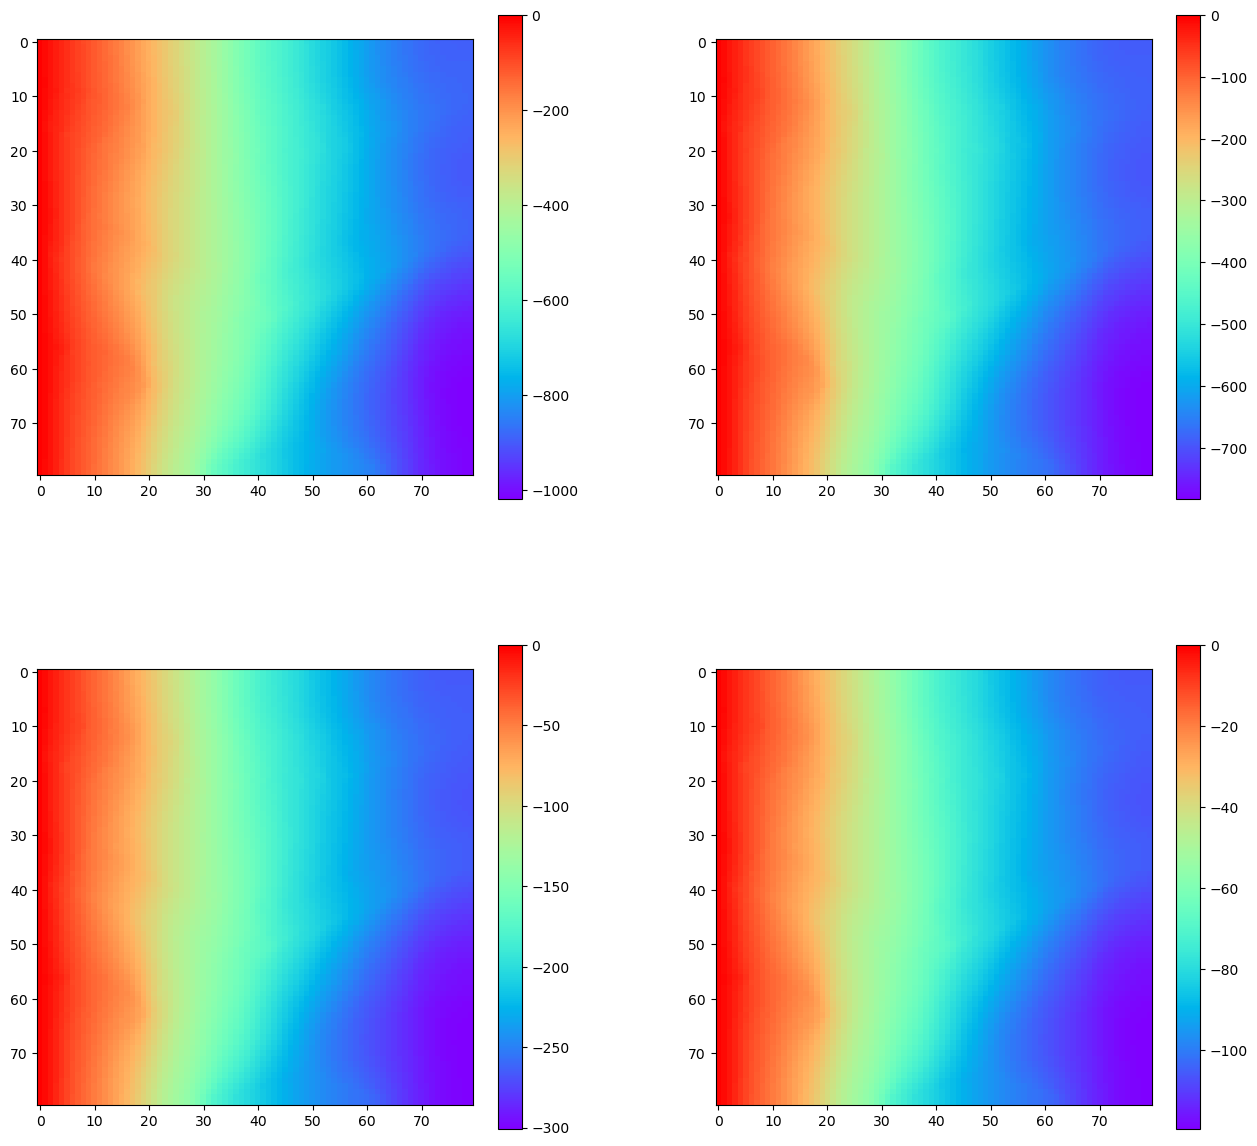

In [17]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(wspace=0.4)

ax0 = fig.add_subplot(2, 2, 1)
im0 = ax0.imshow(hds.get_data(kstpkper=(10, 1))[0],cmap="rainbow")
plt.colorbar(im0, fraction=0.05, pad=0.05)
ax1 = fig.add_subplot(2, 2, 2)
im1 = ax1.imshow(hds.get_data(kstpkper=(20, 1))[0], cmap="rainbow")
plt.colorbar(im1, fraction=0.05, pad=0.05)
ax2 = fig.add_subplot(2, 2, 3)
im2 = ax2.imshow(hds.get_data(kstpkper=(60, 1))[0], cmap="rainbow")
plt.colorbar(im2, fraction=0.05, pad=0.05)
ax3 = fig.add_subplot(2, 2, 4)
im3 = ax3.imshow(hds.get_data(kstpkper=(99, 1))[0], cmap="rainbow")
plt.colorbar(im3, fraction=0.05, pad=0.05)

plt.show()


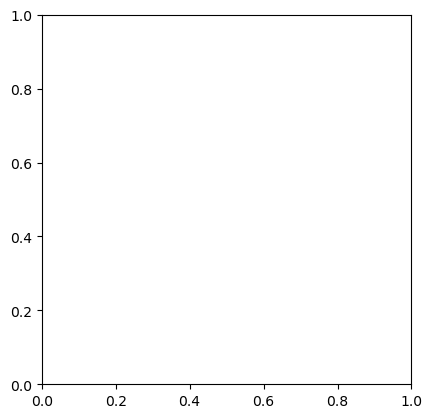

In [18]:
flopy.plot.PlotMapView(mf)